# Test for different SME solvers against analytical solution for oscillator squeezing

Manuel Grimm, Niels Lörch, and Denis V. Vasilyev

30 August 2016

Updated by Eric Giguere
March 2018

We solve the stochastic master equation for an oscillator coupled to a 1D field as discussed in [1]. There is a deterministic differential equation for the variances of the oscillator quadratures $\langle\delta X^2\rangle$ and $\langle\delta P^2\rangle$. This allows for a direct comparison between the numerical solution and the exact solution for a single quantum trajectory. In particular, we study scaling of deviations from analytical solution as a function of stepsize for different solvers:
'euler-maruyama', 'pc-euler', 'milstein', 'milstein-imp', 'taylor15', 'taylor15-imp'.

It is important to check the correct scaling since it is very easy to implement a higher order method in a wrong way such that it still works but as a lower order method.

In this section we solve SME with a single Wiener increment: 
### $\mathrm{d}\rho = D[s]\rho\mathrm{d}t + H[s]\rho \mathrm{d}W + \gamma D[a]\rho\mathrm{d}t$

The steady state solution for the variance $V_{\mathrm{c}} = \langle X^2\rangle - \langle X\rangle^2$ reads

$V_{\mathrm{c}} = \frac1{4\alpha^{2}}\left[\alpha\beta - \gamma + \sqrt{(\gamma-\alpha\beta )^{2} + 4\gamma \alpha^2}\right]$

where $\alpha$ and $\beta$ are parametrizing the interaction between light and the oscillator such that the jump operator is given by $s = \frac{\alpha+\beta}2 a + \frac{\alpha-\beta}2 a^{\dagger}$

[1] D. V. Vasilyev, C. a. Muschik, and K. Hammerer, Physical Review A 87, 053820 (2013). <a href="http://arxiv.org/abs/1303.5888">arXiv:1303.5888</a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from qutip import *
from qutip.ui.progressbar import BaseProgressBar
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
y_sse = None
import time

## Just check that analytical solution coincides with the solution of ODE for the variance

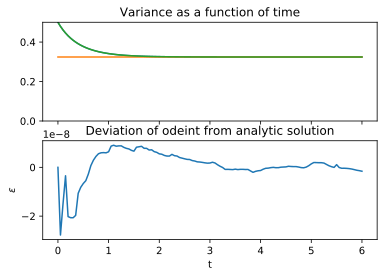

In [2]:
def arccoth(x):
    return 0.5*np.log((1.+x)/(x-1.))

############ parameters #############

th = 0.1 # Interaction parameter
alpha = np.cos(th)
beta = np.sin(th)
gamma = 1.
def gammaf(t):
    return 0.25+t/12+t*t/6

def f_gamma(t,*args):
    return (0.25+t/12+t*t/6)**(0.5)

################# Solution of the differential equation for the variance Vc ####################
T = 6.
N_store = int(20*T+1)
tlist = np.linspace(0,T,N_store)
y0 = 0.5
def func(y, t):
    return -(gammaf(t) - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gammaf(t)
y_td = odeint(func, y0, tlist)
y_td = y_td.ravel()

def func(y, t):
    return -(gamma - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gamma
y = odeint(func, y0, tlist)

############ Exact steady state solution for Vc #########################
Vc = (alpha*beta - gamma + np.sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha**2))/(4*alpha**2)

#### Analytic solution
A = (gamma**2 + alpha**2 * (beta**2 + 4*gamma) - 2*alpha*beta*gamma)**0.5
B = arccoth((-4*alpha**2*y0 + alpha*beta - gamma)/A)
y_an = (alpha*beta - gamma + A / np.tanh(0.5*A*tlist - B))/(4*alpha**2)

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.set_title('Variance as a function of time')
ax.plot(tlist,y)
ax.plot(tlist,Vc*np.ones_like(tlist))
ax.plot(tlist,y_an)
ax.set_ylim(0,0.5)

ax2.set_title('Deviation of odeint from analytic solution')
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\epsilon$')
ax2.plot(tlist,y_an - y.T[0]);

In [3]:
####################### Model ###########################

N = 30                 # number of Fock states
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/np.sqrt(2)
H = Id
c_op = [np.sqrt(gamma)*a]
c_op_td = [[a,f_gamma]]
sc_op = [s]
e_op = [x, x*x]
rho0 = fock_dm(N,0)       # initial vacuum state
#sc_len=1                 # one stochastic operator


############## time steps and trajectories ###################

ntraj = 1 #100           # number of trajectories
T = 6.                   # final time          
N_store = int(20*T+1)    # number of time steps for which we save the expectation values/density matrix
tlist = np.linspace(0,T,N_store)
ddt = (tlist[1]-tlist[0])

Nsubs = (10*np.logspace(0,1,10)).astype(int)
stepsizes = [ddt/j for j in Nsubs] # step size is doubled after each evaluation 
Nt = len(Nsubs)                    # number of step sizes that we compare
Nsubmax = Nsubs[-1]                # Number of intervals for the smallest step size; 
dtmin = (tlist[1]-tlist[0])/(Nsubmax)


## Test of different SME solvers

## Plotting the figure

In [4]:
ntraj = 1

def run_cte_cte(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for j in range(0,ntraj):
        for jj in range(0,Nt):
            Nsub = Nsubs[jj]
            sol = smesolve(H, rho0, tlist, c_op, sc_op, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_an - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats_cte_cte(**kw):
    start = time.time()
    y = run_cte_cte(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit,time.time()-start

stats_cte_cte = []
stats_cte_cte.append(get_stats_cte_cte(solver='euler-maruyama'))

stats_cte_cte.append(get_stats_cte_cte(solver='platen'))
stats_cte_cte.append(get_stats_cte_cte(solver='pred-corr'))
stats_cte_cte.append(get_stats_cte_cte(solver='milstein'))
stats_cte_cte.append(get_stats_cte_cte(solver='milstein-imp'))
stats_cte_cte.append(get_stats_cte_cte(solver='pred-corr-2'))

stats_cte_cte.append(get_stats_cte_cte(solver='explicit1.5'))
stats_cte_cte.append(get_stats_cte_cte(solver="taylor1.5"))
stats_cte_cte.append(get_stats_cte_cte(solver="taylor1.5-imp", args={"tol":1e-8}))

stats_cte_cte.append(get_stats_cte_cte(solver="taylor2.0"))
stats_cte_cte.append(get_stats_cte_cte(solver="taylor2.0", noiseDepth=500))

{'solver': 'euler-maruyama'}
Total run time:   0.05s
Total run time:   0.07s
Total run time:   0.11s
Total run time:   0.11s
Total run time:   0.16s
Total run time:   0.19s
Total run time:   0.27s
Total run time:   0.36s
Total run time:   0.42s
Total run time:   0.55s
{'solver': 'platen'}
Total run time:   0.16s
Total run time:   0.21s
Total run time:   0.27s
Total run time:   0.36s
Total run time:   0.45s
Total run time:   0.61s
Total run time:   0.74s
Total run time:   0.95s
Total run time:   1.24s
Total run time:   1.64s
{'solver': 'pred-corr'}
Total run time:   0.14s
Total run time:   0.16s
Total run time:   0.18s
Total run time:   0.25s
Total run time:   0.32s
Total run time:   0.41s
Total run time:   0.54s
Total run time:   0.68s
Total run time:   0.89s
Total run time:   1.15s
{'solver': 'milstein'}
Total run time:   0.08s
Total run time:   0.09s
Total run time:   0.17s
Total run time:   0.16s
Total run time:   0.22s
Total run time:   0.28s
Total run time:   0.37s
Total run time:

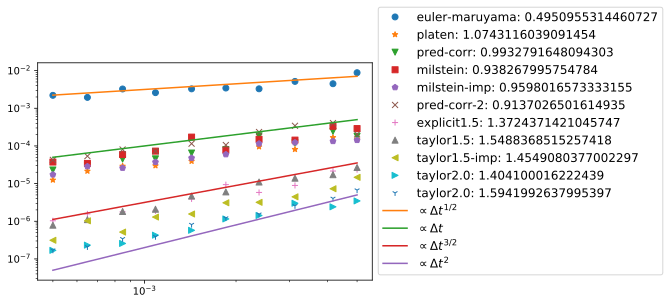

In [5]:
fig = plt.figure()
ax = plt.subplot(111)

mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_cte_cte):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")
ax.loglog(stepsizes, 0.2*np.array(stepsizes)**2.0, label="$\propto\Delta t^{2}$")

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Deterministic part depend on time

In [6]:
ntraj = 1
def run_(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for j in range(0,ntraj):
        for jj in range(0,Nt):
            Nsub = Nsubs[jj]
            sol = smesolve(H, rho0, tlist, c_op_td, sc_op, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_td - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats_d1(**kw):
    start = time.time()
    y = run_(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit,time.time()-start

stat_d1 = []
stat_d1.append(get_stats_d1(solver='euler-maruyama'))

stat_d1.append(get_stats_d1(solver='platen'))
stat_d1.append(get_stats_d1(solver='pc-euler'))
stat_d1.append(get_stats_d1(solver='milstein'))
stat_d1.append(get_stats_d1(solver='milstein-imp'))
stat_d1.append(get_stats_d1(solver='pc-euler-2'))

stat_d1.append(get_stats_d1(solver='explicit1.5'))
stat_d1.append(get_stats_d1(solver="taylor1.5"))
stat_d1.append(get_stats_d1(solver="taylor1.5-imp", args={"tol":1e-8}))

stat_d1.append(get_stats_d1(solver="taylor2.0"))
stat_d1.append(get_stats_d1(solver="taylor2.0", noiseDepth=500))

{'solver': 'euler-maruyama'}
Total run time:   0.25s
Total run time:   0.13s
Total run time:   0.18s
Total run time:   0.23s
Total run time:   0.29s
Total run time:   0.38s
Total run time:   0.52s
Total run time:   0.60s
Total run time:   0.80s
Total run time:   0.99s
{'solver': 'platen'}
Total run time:   0.28s
Total run time:   0.32s
Total run time:   0.42s
Total run time:   0.54s
Total run time:   0.69s
Total run time:   0.88s
Total run time:   1.20s
Total run time:   1.50s
Total run time:   1.93s
Total run time:   2.55s
{'solver': 'pc-euler'}
Total run time:   0.16s
Total run time:   0.21s
Total run time:   0.28s
Total run time:   0.37s
Total run time:   0.45s
Total run time:   0.57s
Total run time:   0.76s
Total run time:   1.00s
Total run time:   1.24s
Total run time:   1.62s
{'solver': 'milstein'}
Total run time:   0.13s
Total run time:   0.17s
Total run time:   0.21s
Total run time:   0.28s
Total run time:   0.35s
Total run time:   0.44s
Total run time:   0.59s
Total run time: 

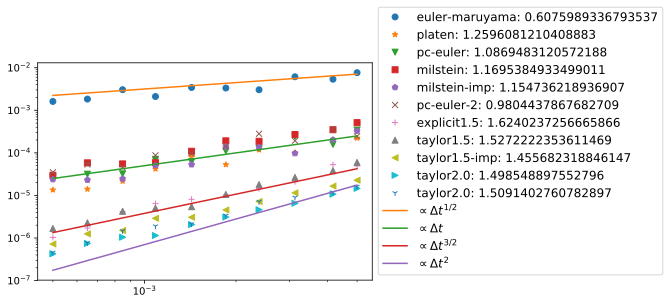

In [7]:
fig = plt.figure()
ax = plt.subplot(111)

mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stat_d1):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.05*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.12*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")
ax.loglog(stepsizes, 0.7*np.array(stepsizes)**2.0, label="$\propto\Delta t^{2}$")


lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Both d1 and d2 time-dependent
Using a taylor simulation with large nsubsteps instead of analytical solution.

Total run time:  90.46s


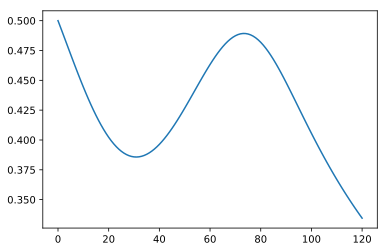

In [8]:
def f(t, args):
    return 0.5+0.25*t-t*t*0.125

Nsubs = (15*np.logspace(0,0.8,10)).astype(int)
stepsizes = [ddt/j for j in Nsubs] # step size is doubled after each evaluation 
Nt = len(Nsubs)                    # number of step sizes that we compare
Nsubmax = Nsubs[-1]                # Number of intervals for the smallest step size; 
dtmin = (tlist[1]-tlist[0])/(Nsubmax)

sc_op_td = [[sc_op[0],f]]
sol = smesolve(H, rho0, tlist, c_op_td, sc_op_td, e_op, nsubsteps=1000, method="homodyne",solver="taylor15")
y_btd = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()
plt.plot(y_btd)

In [9]:
ntraj = 1

def run_(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for j in range(0,ntraj):
        for jj in range(0,Nt):
            Nsub = Nsubs[jj]
            sol = smesolve(H, rho0, tlist, c_op_td, sc_op_td, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_btd - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats_d2(**kw):
    start = time.time()
    y = run_(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit,time.time()-start

stats_d2 = []
stats_d2.append(get_stats_d2(solver='euler-maruyama'))

stats_d2.append(get_stats_d2(solver='platen'))
stats_d2.append(get_stats_d2(solver='pc-euler'))
stats_d2.append(get_stats_d2(solver='milstein'))
stats_d2.append(get_stats_d2(solver='milstein-imp'))
stats_d2.append(get_stats_d2(solver='pc-euler-2'))

stats_d2.append(get_stats_d2(solver='explicit1.5'))
stats_d2.append(get_stats_d2(solver='taylor1.5'))
stats_d2.append(get_stats_d2(solver='taylor1.5-imp', args={"tol":2e-9}))

{'solver': 'euler-maruyama'}
Total run time:   0.24s
Total run time:   0.39s
Total run time:   0.35s
Total run time:   0.43s
Total run time:   0.62s
Total run time:   0.63s
Total run time:   0.79s
Total run time:   0.92s
Total run time:   1.14s
Total run time:   1.38s
{'solver': 'platen'}
Total run time:   0.55s
Total run time:   0.65s
Total run time:   0.84s
Total run time:   1.28s
Total run time:   1.24s
Total run time:   1.77s
Total run time:   3.18s
Total run time:   2.64s
Total run time:   4.25s
Total run time:   4.50s
{'solver': 'pc-euler'}
Total run time:   0.39s
Total run time:   0.45s
Total run time:   0.55s
Total run time:   0.67s
Total run time:   0.84s
Total run time:   1.01s
Total run time:   1.28s
Total run time:   1.52s
Total run time:   1.88s
Total run time:   2.65s
{'solver': 'milstein'}
Total run time:   0.31s
Total run time:   0.36s
Total run time:   0.43s
Total run time:   0.53s
Total run time:   0.66s
Total run time:   0.79s
Total run time:   0.98s
Total run time: 

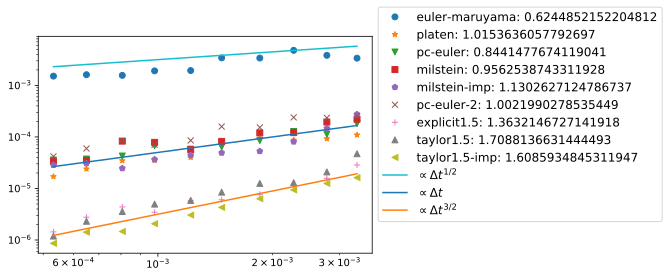

In [10]:
fig = plt.figure()
ax = plt.subplot(111)

mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_d2):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.05*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")


lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Multiple sc_ops with time dependence

Total run time: 160.70s


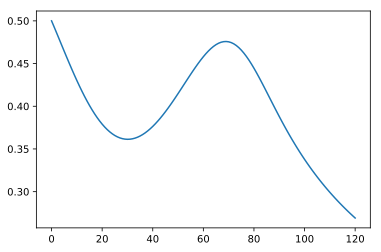

In [11]:
def f(t, args):
    return 0.5+0.25*t-t*t*0.125

def g(t, args):
    return 0.25+0.25*t-t*t*0.125

Nsubs = (20*np.logspace(0,0.6,8)).astype(int)
stepsizes = [ddt/j for j in Nsubs] # step size is doubled after each evaluation 
Nt = len(Nsubs)                    # number of step sizes that we compare
Nsubmax = Nsubs[-1]                # Number of intervals for the smallest step size; 
dtmin = (tlist[1]-tlist[0])/(Nsubmax)

sc_op2_td = [[sc_op[0],f],[sc_op[0],g]]
sol = smesolve(H, rho0, tlist, c_op_td, sc_op2_td, e_op, nsubsteps=1000, method="homodyne",solver=152)
y_btd2 = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()
plt.plot(y_btd2)

In [12]:
ntraj = 1

def run_multi(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for j in range(0,ntraj):
        for jj in range(0,Nt):
            Nsub = Nsubs[jj]
            sol = smesolve(H, rho0, tlist, c_op_td, sc_op2_td, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_btd2 - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats_multi(**kw):
    start = time.time()
    y = run_multi(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit,time.time()-start

stats_multi = []
stats_multi.append(get_stats_multi(solver='euler-maruyama'))

stats_multi.append(get_stats_multi(solver='platen'))
stats_multi.append(get_stats_multi(solver='pc-euler'))
stats_multi.append(get_stats_multi(solver='milstein'))
stats_multi.append(get_stats_multi(solver='milstein-imp'))
stats_multi.append(get_stats_multi(solver='pc-euler-2'))

stats_multi.append(get_stats_multi(solver='explicit1.5'))
stats_multi.append(get_stats_multi(solver="taylor1.5"))
stats_multi.append(get_stats_multi(solver="taylor1.5-imp"))

{'solver': 'euler-maruyama'}
Total run time:   0.53s
Total run time:   0.58s
Total run time:   0.70s
Total run time:   0.87s
Total run time:   1.08s
Total run time:   1.28s
Total run time:   1.57s
Total run time:   2.01s
{'solver': 'platen'}
Total run time:   1.52s
Total run time:   1.82s
Total run time:   2.21s
Total run time:   2.78s
Total run time:   3.33s
Total run time:   4.05s
Total run time:   4.97s
Total run time:   6.01s
{'solver': 'pc-euler'}
Total run time:   0.92s
Total run time:   1.10s
Total run time:   1.33s
Total run time:   1.64s
Total run time:   2.01s
Total run time:   2.41s
Total run time:   3.05s
Total run time:   3.60s
{'solver': 'milstein'}
Total run time:   0.73s
Total run time:   0.88s
Total run time:   1.06s
Total run time:   1.32s
Total run time:   1.62s
Total run time:   1.96s
Total run time:   2.37s
Total run time:   2.88s
{'solver': 'milstein-imp'}
Total run time:   3.11s
Total run time:   3.61s
Total run time:   4.36s
Total run time:   5.51s
Total run tim

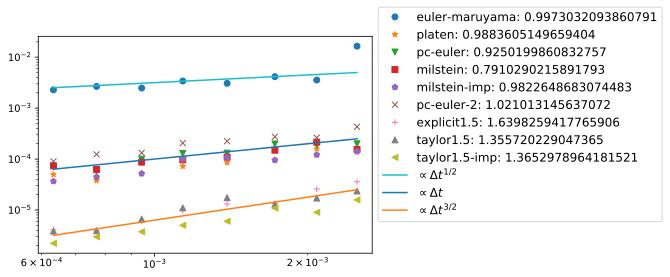

In [13]:
fig = plt.figure()
ax = plt.subplot(111)

mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_multi):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.2*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Versions

In [14]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+1cf1dd3e
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.2
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
